# Programming Exercise 6:

# Support Vector Machines

## Introduction

In this exercise, you will be using support vector machines (SVMs) to build a spam classifier. Before starting the programming exercise, we strongly recommend reading the lectures for the associated topics.

All the information you need for solving this assignment is in this notebook, and all the code you will be implementing will take place within this notebook.

Before we begin with the exercises, we need to import all libraries required for this programming exercise. Throughout the course, we will be using [`numpy`](http://www.numpy.org/) for all arrays and matrix operations, [`matplotlib`](https://matplotlib.org/) for plotting, and [`scipy`](https://docs.scipy.org/doc/scipy/reference/) for scientific and numerical computation functions and tools.


In [1]:
# # If you are using Google Colab
# from google.colab import drive
# drive.mount('/content/drive/')
# %cd '/content/drive/My Drive/FML/Laboratory 06/'

In [2]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Import regular expressions to process emails
import re

# Plotting library
from matplotlib import pyplot

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# library written for this exercise providing additional functions for this assignment
import utils

# tells matplotlib to embed plots within the notebook
%matplotlib inline

## Grading

The following is a breakdown of how each part of this exercise is scored.

| Section | Part                                                | Function                            | Points |
| :------ | :-------------------------------------------------- | :---------------------------------- | :----: |
| 1       | [Gaussian Kernel](#section1)                        | [`gaussianKernel`](#gaussianKernel) |   25   |
| 2       | [Parameters (C, $\sigma$) for Dataset 3](#section2) | [`dataset3Params`](#dataset3Params) |   25   |
| 3       | [Email Preprocessing](#section3)                    | [`processEmail`](#processEmail)     |   25   |
| 4       | [Email Feature Extraction](#section4)               | [`emailFeatures`](#emailFeatures)   |   25   |
|         | Total Points                                        |                                     |  100   |


## 1 Support Vector Machines

In the first half of this exercise, you will be using support vector machines (SVMs) with various example 2D datasets. Experimenting with these datasets will help you gain an intuition of how SVMs work and how to use a Gaussian kernel with SVMs. In the next half of the exercise, you will be using support
vector machines to build a spam classifier.


### 1.1 Example Dataset 1

We will begin by with a 2D example dataset which can be separated by a linear boundary. The following cell plots the training data, which should look like this:

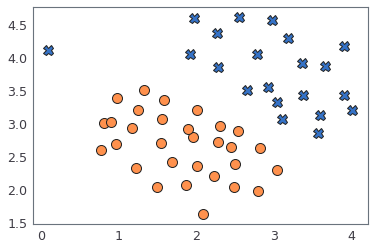

In this dataset, the positions of the positive examples (indicated with `x`) and the negative examples (indicated with `o`) suggest a natural separation indicated by the gap. However, notice that there is an outlier positive example `x` on the far left at about (0.1, 4.1). As part of this exercise, you will also see how this outlier affects the SVM decision boundary.


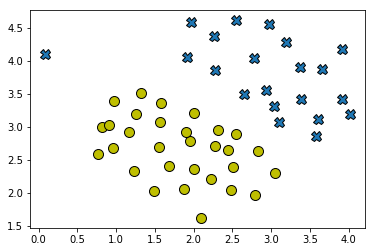

In [3]:
# Load from ex6data1
# You will have X, y as keys in the dict data
data = loadmat(os.path.join('Data', 'ex6data1.mat'))
X, y = data['X'], data['y'][:, 0]

# Plot training data
utils.plotData(X, y)

In this part of the exercise, you will try using different values of the $C$ parameter with SVMs. Informally, the $C$ parameter is a positive value that controls the penalty for misclassified training examples. A large $C$ parameter tells the SVM to try to classify all the examples correctly. $C$ plays a role similar to $1/\lambda$, where $\lambda$ is the regularization parameter that we were using previously for logistic regression.

The following cell will run the SVM training (with $C=1$) using SVM software that we have included with the starter code (function `svmTrain` within the `utils` module of this exercise). When $C=1$, you should find that the SVM puts the decision boundary in the gap between the two datasets and _misclassifies_ the data point on the far left, as shown in the figure (left) below.

C=1

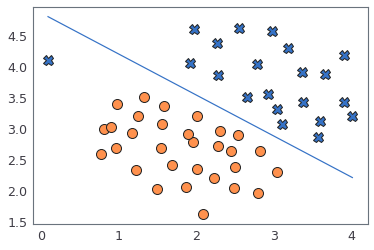

C=100

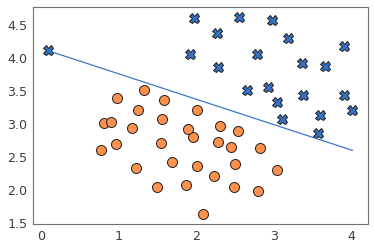

<div class="alert alert-block alert-warning">
In order to minimize the dependency of this assignment on external libraries, we have included this implementation of an SVM learning algorithm in utils.svmTrain. However, this particular implementation is not very efficient (it was originally chosen to maximize compatibility between Octave/MATLAB for the first version of this assignment set). If you are training an SVM on a real problem, especially if you need to scale to a larger dataset, we strongly recommend instead using a highly optimized SVM toolbox such as [LIBSVM](https://www.csie.ntu.edu.tw/~cjlin/libsvm/). The python machine learning library [scikit-learn](http://scikit-learn.org/stable/index.html) provides wrappers for the LIBSVM library.
</div>
<br/>
<div class="alert alert-block alert-warning">
**Implementation Note:** Most SVM software packages (including the function `utils.svmTrain`) automatically add the extra feature $x_0$ = 1 for you and automatically take care of learning the intercept term $\theta_0$. So when passing your training data to the SVM software, there is no need to add this extra feature $x_0 = 1$ yourself. In particular, in python your code should be working with training examples $x \in \mathcal{R}^n$ (rather than $x \in \mathcal{R}^{n+1}$); for example, in the first example dataset $x \in \mathcal{R}^2$.
</div>

Your task is to try different values of $C$ on this dataset. Specifically, you should change the value of $C$ in the next cell to $C = 100$ and run the SVM training again. When $C = 100$, you should find that the SVM now classifies every single example correctly, but has a decision boundary that does not
appear to be a natural fit for the data.


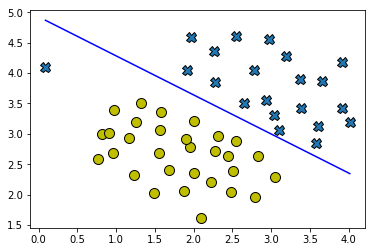

In [4]:
# You should try to change the C value below and see how the decision
# boundary varies (e.g., try C = 1000)
C = 1

model = utils.svmTrain(X, y, C, utils.linearKernel, 1e-3, 20)
utils.visualizeBoundaryLinear(X, y, model)

<a id="section1"></a>

### 1.2 SVM with Gaussian Kernels

In this part of the exercise, you will be using SVMs to do non-linear classification. In particular, you will be using SVMs with Gaussian kernels on datasets that are not linearly separable.

#### 1.2.1 Gaussian Kernel

To find non-linear decision boundaries with the SVM, we need to first implement a Gaussian kernel. You can think of the Gaussian kernel as a similarity function that measures the “distance” between a pair of examples,
($x^{(i)}$, $x^{(j)}$). The Gaussian kernel is also parameterized by a bandwidth parameter, $\sigma$, which determines how fast the similarity metric decreases (to 0) as the examples are further apart.
You should now complete the code in `gaussianKernel` to compute the Gaussian kernel between two examples, ($x^{(i)}$, $x^{(j)}$). The Gaussian kernel function is defined as:

$$ K*{\text{gaussian}} \left( x^{(i)}, x^{(j)} \right) = \exp \left( - \frac{\left\lvert\left\lvert x^{(i)} - x^{(j)}\right\lvert\right\lvert^2}{2\sigma^2} \right) = \exp \left( -\frac{\sum*{k=1}^n \left( x_k^{(i)} - x_k^{(j)}\right)^2}{2\sigma^2} \right)$$
<a id="gaussianKernel"></a>


In [10]:
def gaussianKernel(x1, x2, sigma):
    """
    Computes the radial basis function
    Returns a radial basis function kernel between x1 and x2.

    Parameters
    ----------
    x1 :  numpy ndarray
        A vector of size (n, ), representing the first datapoint.

    x2 : numpy ndarray
        A vector of size (n, ), representing the second datapoint.

    sigma : float
        The bandwidth parameter for the Gaussian kernel.

    Returns
    -------
    sim : float
        The computed RBF between the two provided data points.

    Instructions
    ------------
    Fill in this function to return the similarity between `x1` and `x2`
    computed using a Gaussian kernel with bandwidth `sigma`.
    """
    sim = 0
    # ====================== YOUR CODE HERE ======================
    sim = np.exp(-np.sum(np.square(x1 - x2)) / (2 * sigma ** 2))
    # =============================================================
    return sim

Once you have completed the function `gaussianKernel` the following cell will test your kernel function on two provided examples and you should expect to see a value of 0.324652.


In [11]:
x1 = np.array([1, 2, 1])
x2 = np.array([0, 4, -1])
sigma = 2

sim = gaussianKernel(x1, x2, sigma)

print('Gaussian Kernel between x1 = [1, 2, 1], x2 = [0, 4, -1], sigma = %0.2f:'
      '\n\t%f\n(for sigma = 2, this value should be about 0.324652)\n' % (sigma, sim))

Gaussian Kernel between x1 = [1, 2, 1], x2 = [0, 4, -1], sigma = 2.00:
	0.324652
(for sigma = 2, this value should be about 0.324652)



### 1.2.2 Example Dataset 2

The next part in this notebook will load and plot dataset 2, as shown in the figure below.

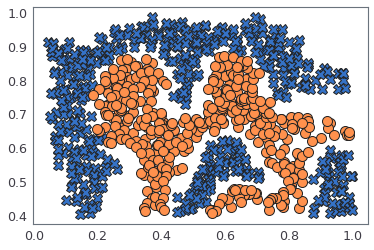


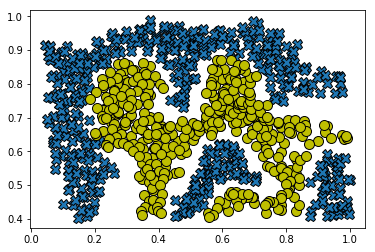

In [7]:
# Load from ex6data2
# You will have X, y as keys in the dict data
data = loadmat(os.path.join('Data', 'ex6data2.mat'))
X, y = data['X'], data['y'][:, 0]

# Plot training data
utils.plotData(X, y)

From the figure, you can obserse that there is no linear decision boundary that separates the positive and negative examples for this dataset. However, by using the Gaussian kernel with the SVM, you will be able to learn a non-linear decision boundary that can perform reasonably well for the dataset. If you have correctly implemented the Gaussian kernel function, the following cell will proceed to train the SVM with the Gaussian kernel on this dataset.

You should get a decision boundary as shown in the figure below, as computed by the SVM with a Gaussian kernel. The decision boundary is able to separate most of the positive and negative examples correctly and follows the contours of the dataset well.

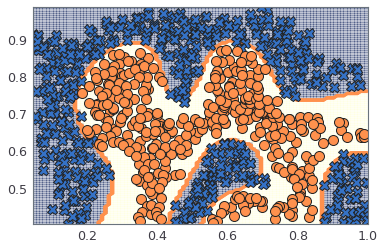


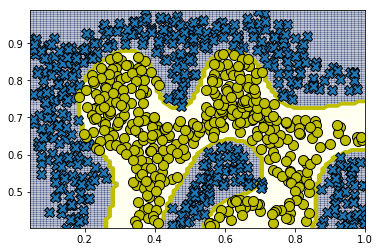

In [8]:
# SVM Parameters
C = 1
sigma = 0.1

model= utils.svmTrain(X, y, C, gaussianKernel, args=(sigma,))
utils.visualizeBoundary(X, y, model)

<a id="section2"></a>

#### 1.2.3 Example Dataset 3

In this part of the exercise, you will gain more practical skills on how to use a SVM with a Gaussian kernel. The next cell will load and display a third dataset, which should look like the figure below.

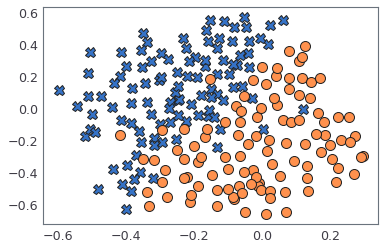

You will be using the SVM with the Gaussian kernel with this dataset. In the provided dataset, `ex6data3.mat`, you are given the variables `X`, `y`, `Xval`, `yval`.


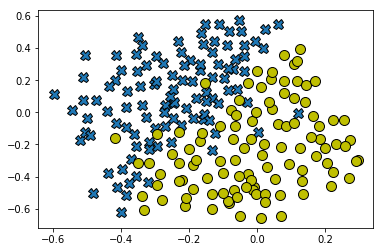

In [9]:
# Load from ex6data3
# You will have X, y, Xval, yval as keys in the dict data
data = loadmat(os.path.join('Data', 'ex6data3.mat'))
X, y, Xval, yval = data['X'], data['y'][:, 0], data['Xval'], data['yval'][:, 0]

# Plot training data
utils.plotData(X, y)

Your task is to use the cross validation set `Xval`, `yval` to determine the best $C$ and $\sigma$ parameter to use. You should write any additional code necessary to help you search over the parameters $C$ and $\sigma$. For both $C$ and $\sigma$, we suggest trying values in multiplicative steps (e.g., 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30).
Note that you should try all possible pairs of values for $C$ and $\sigma$ (e.g., $C = 0.3$ and $\sigma = 0.1$). For example, if you try each of the 8 values listed above for $C$ and for $\sigma^2$, you would end up training and evaluating (on the cross validation set) a total of $8^2 = 64$ different models. After you have determined the best $C$ and $\sigma$ parameters to use, you should modify the code in `dataset3Params`, filling in the best parameters you found. For our best parameters, the SVM returned a decision boundary shown in the figure below.

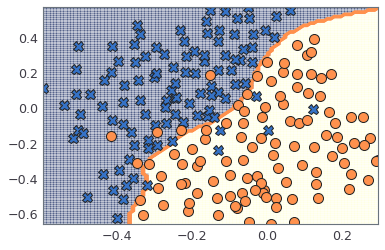

<div class="alert alert-block alert-warning">
**Implementation Tip:** When implementing cross validation to select the best $C$ and $\sigma$ parameter to use, you need to evaluate the error on the cross validation set. Recall that for classification, the error is defined as the fraction of the cross validation examples that were classified incorrectly. In `numpy`, you can compute this error using `np.mean(predictions != yval)`, where `predictions` is a vector containing all the predictions from the SVM, and `yval` are the true labels from the cross validation set. You can use the `utils.svmPredict` function to generate the predictions for the cross validation set.
</div>
<a id="dataset3Params"></a>


In [12]:
def dataset3Params(X, y, Xval, yval):
    """
    Returns your choice of C and sigma for Part 3 of the exercise
    where you select the optimal (C, sigma) learning parameters to use for SVM
    with RBF kernel.

    Parameters
    ----------
    X : array_like
        (m x n) matrix of training data where m is number of training examples, and
        n is the number of features.

    y : array_like
        (m, ) vector of labels for ther training data.

    Xval : array_like
        (mv x n) matrix of validation data where mv is the number of validation examples
        and n is the number of features

    yval : array_like
        (mv, ) vector of labels for the validation data.

    Returns
    -------
    C, sigma : float, float
        The best performing values for the regularization parameter C and
        RBF parameter sigma.

    Instructions
    ------------
    Fill in this function to return the optimal C and sigma learning
    parameters found using the cross validation set.
    You can use `svmPredict` to predict the labels on the cross
    validation set. For example,

        predictions = utils.svmPredict(model, Xval)

    will return the predictions on the cross validation set.

    Note
    ----
    You can compute the prediction error using

        np.mean(predictions != yval)
    """
    # You need to return the following variables correctly.
    C = 1
    sigma = 0.3

    # ====================== YOUR CODE HERE ======================
    Cs = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
    sigmas = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]

    error = np.inf
    for C_ in Cs:
        for sigma_ in sigmas:
            model = utils.svmTrain(X, y, C_, gaussianKernel, args=(sigma_,))
            predictions = utils.svmPredict(model, Xval)
            error_ = np.mean(predictions != yval)
            if error_ < error:
                error = error_
                C = C_
                sigma = sigma_
    # ============================================================
    return C, sigma

The provided code in the next cell trains the SVM classifier using the training set $(X, y)$ using parameters loaded from `dataset3Params`. Note that this might take a few minutes to execute.


1 0.1


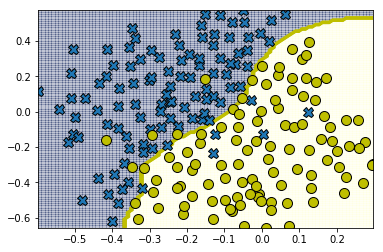

In [ ]:
# Try different SVM Parameters here
C, sigma = dataset3Params(X, y, Xval, yval)

# Train the SVM
model = utils.svmTrain(X, y, C, gaussianKernel, args=(sigma,))
utils.visualizeBoundary(X, y, model)
print(C, sigma)

<a id="section3"></a>

## 2 Spam Classification

Many email services today provide spam filters that are able to classify emails into spam and non-spam email with high accuracy. In this part of the exercise, you will use SVMs to build your own spam filter.

You will be training a classifier to classify whether a given email, $x$, is spam ($y = 1$) or non-spam ($y = 0$). In particular, you need to convert each email into a feature vector $x \in \mathbb{R}^n$ . The following parts of the exercise will walk you through how such a feature vector can be constructed from an email.

The dataset included for this exercise is based on a a subset of the [SpamAssassin Public Corpus](http://spamassassin.apache.org/old/publiccorpus/). For the purpose of this exercise, you will only be using the body of the email (excluding the email headers).


### 2.1 Preprocessing Emails

Before starting on a machine learning task, it is usually insightful to take a look at examples from the dataset. The figure below shows a sample email that contains a URL, an email address (at the end), numbers, and dollar
amounts.

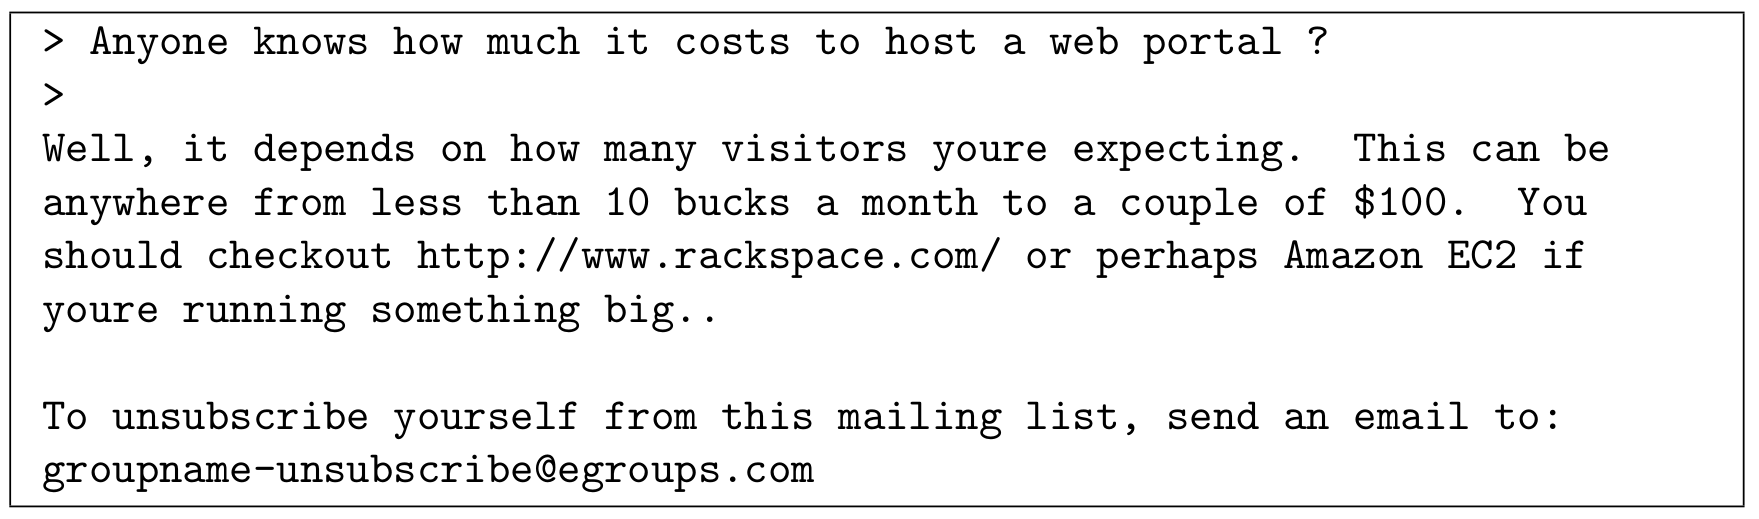

While many emails would contain similar types of entities (e.g., numbers, other URLs, or other email addresses), the specific entities (e.g., the specific URL or specific dollar amount) will be different in almost every
email. Therefore, one method often employed in processing emails is to “normalize” these values, so that all URLs are treated the same, all numbers are treated the same, etc. For example, we could replace each URL in the
email with the unique string “httpaddr” to indicate that a URL was present.

This has the effect of letting the spam classifier make a classification decision based on whether any URL was present, rather than whether a specific URL was present. This typically improves the performance of a spam classifier, since spammers often randomize the URLs, and thus the odds of seeing any particular URL again in a new piece of spam is very small.

In the function `processEmail` below, we have implemented the following email preprocessing and normalization steps:

- **Lower-casing**: The entire email is converted into lower case, so that captialization is ignored (e.g., IndIcaTE is treated the same as Indicate).

- **Stripping HTML**: All HTML tags are removed from the emails. Many emails often come with HTML formatting; we remove all the HTML tags, so that only the content remains.

- **Normalizing URLs**: All URLs are replaced with the text “httpaddr”.

- **Normalizing Email Addresses**: All email addresses are replaced with the text “emailaddr”.

- **Normalizing Numbers**: All numbers are replaced with the text “number”.

- **Normalizing Dollars**: All dollar signs ($) are replaced with the text “dollar”.

- **Word Stemming**: Words are reduced to their stemmed form. For example, “discount”, “discounts”, “discounted” and “discounting” are all replaced with “discount”. Sometimes, the Stemmer actually strips off additional characters from the end, so “include”, “includes”, “included”, and “including” are all replaced with “includ”.

- **Removal of non-words**: Non-words and punctuation have been removed. All white spaces (tabs, newlines, spaces) have all been trimmed to a single space character.

The result of these preprocessing steps is shown in the figure below.

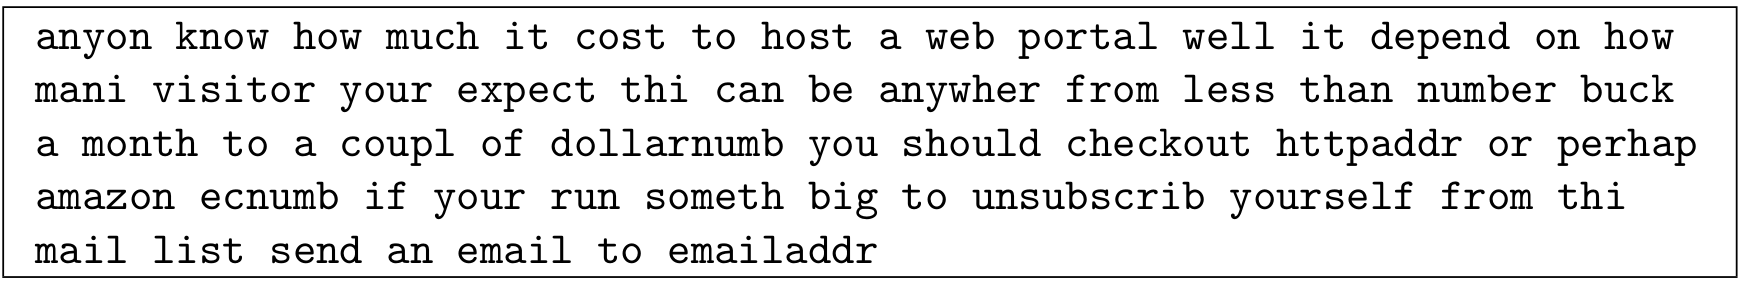

While preprocessing has left word fragments and non-words, this form turns out to be much easier to work with for performing feature extraction.


#### 2.1.1 Vocabulary List

After preprocessing the emails, we have a list of words for each email. The next step is to choose which words we would like to use in our classifier and which we would want to leave out.

For this exercise, we have chosen only the most frequently occuring words as our set of words considered (the vocabulary list). Since words that occur rarely in the training set are only in a few emails, they might cause the
model to overfit our training set. The complete vocabulary list is in the file `vocab.txt` (inside the `Data` directory for this exercise) and also shown in the figure below.

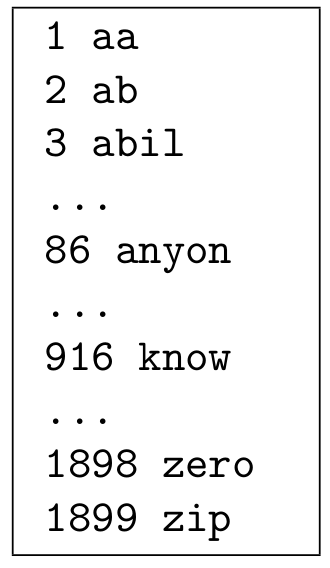

Our vocabulary list was selected by choosing all words which occur at least a 100 times in the spam corpus,
resulting in a list of 1899 words. In practice, a vocabulary list with about 10,000 to 50,000 words is often used.
Given the vocabulary list, we can now map each word in the preprocessed emails into a list of word indices that contains the index of the word in the vocabulary dictionary. The figure below shows the mapping for the sample email. Specifically, in the sample email, the word “anyone” was first normalized to “anyon” and then mapped onto the index 86 in the vocabulary list.

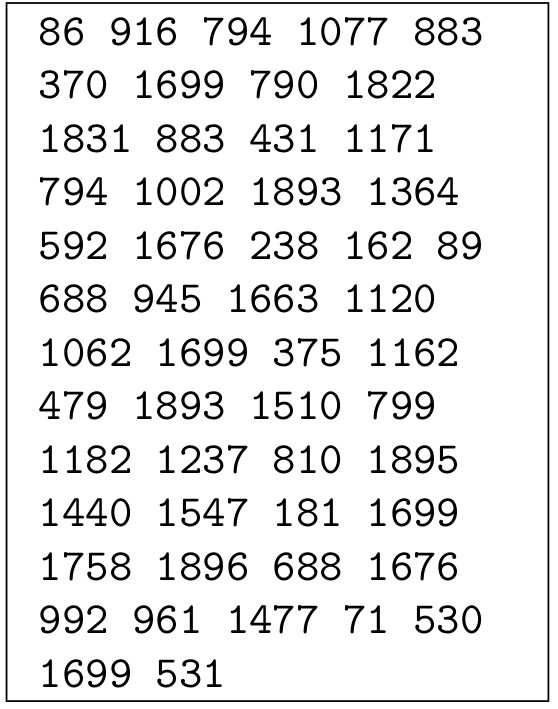

Your task now is to complete the code in the function `processEmail` to perform this mapping. In the code, you are given a string `word` which is a single word from the processed email. You should look up the word in the vocabulary list `vocabList`. If the word exists in the list, you should add the index of the word into the `word_indices` variable. If the word does not exist, and is therefore not in the vocabulary, you can skip the word.

<div class="alert alert-block alert-warning">
**python tip**: In python, you can find the index of the first occurence of an item in `list` using the  `index` attribute. In the provided code for `processEmail`, `vocabList` is a python list containing the words in the vocabulary. To find the index of a word, we can use `vocabList.index(word)` which would return a number indicating the index of the word within the list. If the word does not exist in the list, a `ValueError` exception is raised. In python, we can use the `try/except` statement to catch exceptions which we do not want to stop the program from running. You can think of the `try/except` statement to be the same as an `if/else` statement, but it asks for forgiveness rather than permission.

An example would be:
<br>

```
try:
    do stuff here
except ValueError:
    pass
    # do nothing (forgive me) if a ValueError exception occured within the try statement
```

</div>
<a id="processEmail"></a>


In [ ]:
def processEmail(email_contents, verbose=True):
    """
    Preprocesses the body of an email and returns a list of indices
    of the words contained in the email.

    Parameters
    ----------
    email_contents : str
        A string containing one email.

    verbose : bool
        If True, print the resulting email after processing.

    Returns
    -------
    word_indices : list
        A list of integers containing the index of each word in the
        email which is also present in the vocabulary.

    Instructions
    ------------
    Fill in this function to add the index of word to word_indices
    if it is in the vocabulary. At this point of the code, you have
    a stemmed word from the email in the variable word.
    You should look up word in the vocabulary list (vocabList).
    If a match exists, you should add the index of the word to the word_indices
    list. Concretely, if word = 'action', then you should
    look up the vocabulary list to find where in vocabList
    'action' appears. For example, if vocabList[18] =
    'action', then, you should add 18 to the word_indices
    vector (e.g., word_indices.append(18)).

    Notes
    -----
    - vocabList[idx] returns a the word with index idx in the vocabulary list.

    - vocabList.index(word) return index of word `word` in the vocabulary list.
      (A ValueError exception is raised if the word does not exist.)
    """
    # Load Vocabulary
    vocabList = utils.getVocabList()

    # Init return value
    word_indices = []

    # ========================== Preprocess Email ===========================
    # Find the Headers ( \n\n and remove )
    # Uncomment the following lines if you are working with raw emails with the
    # full headers
    # hdrstart = email_contents.find(chr(10) + chr(10))
    # email_contents = email_contents[hdrstart:]

    # Lower case
    email_contents = email_contents.lower()

    # Strip all HTML
    # Looks for any expression that starts with < and ends with > and replace
    # and does not have any < or > in the tag it with a space
    email_contents =re.compile('<[^<>]+>').sub(' ', email_contents)

    # Handle Numbers
    # Look for one or more characters between 0-9
    email_contents = re.compile('[0-9]+').sub(' number ', email_contents)

    # Handle URLS
    # Look for strings starting with http:// or https://
    email_contents = re.compile('(http|https)://[^\s]*').sub(' httpaddr ', email_contents)

    # Handle Email Addresses
    # Look for strings with @ in the middle
    email_contents = re.compile('[^\s]+@[^\s]+').sub(' emailaddr ', email_contents)

    # Handle $ sign
    email_contents = re.compile('[$]+').sub(' dollar ', email_contents)

    # get rid of any punctuation
    email_contents = re.split('[ @$/#.-:&*+=\[\]?!(){},''">_<;%\n\r]', email_contents)

    # remove any empty word string
    email_contents = [word for word in email_contents if len(word) > 0]

    # Stem the email contents word by word
    stemmer = utils.PorterStemmer()
    processed_email = []
    for word in email_contents:
        # Remove any remaining non alphanumeric characters in word
        word = re.compile('[^a-zA-Z0-9]').sub('', word).strip()
        word = stemmer.stem(word)
        processed_email.append(word)

        if len(word) < 1:
            continue

        # Look up the word in the dictionary and add to word_indices if found
        # ====================== YOUR CODE HERE ======================
        try:
            word_indices.append(vocabList.index(word))
        except ValueError:
            pass
        # =============================================================

    if verbose:
        print('----------------')
        print('Processed email:')
        print('----------------')
        print(' '.join(processed_email))
    return word_indices

Once you have implemented `processEmail`, the following cell will run your code on the email sample and you should see an output of the processed email and the indices list mapping.


In [15]:
#  To use an SVM to classify emails into Spam v.s. Non-Spam, you first need
#  to convert each email into a vector of features. In this part, you will
#  implement the preprocessing steps for each email. You should
#  complete the code in processEmail.m to produce a word indices vector
#  for a given email.

# Extract Features
with open(os.path.join('Data', 'emailSample1.txt')) as fid:
    file_contents = fid.read()

word_indices  = processEmail(file_contents)

#Print Stats
print('-------------')
print('Word Indices:')
print('-------------')
print(word_indices)

----------------
Processed email:
----------------
anyon know how much it cost to host a web portal well it depend on how mani visitor your expect thi can be anywher from less than number buck a month to a coupl of dollar number you should checkout httpaddr or perhap amazon ec number if your run someth big to unsubscrib yourself from thi mail list send an email to emailaddr
-------------
Word Indices:
-------------
[85, 915, 793, 1076, 882, 369, 1698, 789, 1821, 1830, 882, 430, 1170, 793, 1001, 1894, 591, 1675, 237, 161, 88, 687, 944, 1662, 1119, 1061, 1698, 374, 1161, 476, 1119, 1892, 1509, 798, 1181, 1236, 511, 1119, 809, 1894, 1439, 1546, 180, 1698, 1757, 1895, 687, 1675, 991, 960, 1476, 70, 529, 1698, 530]


<a id="section4"></a>

### 2.2 Extracting Features from Emails

You will now implement the feature extraction that converts each email into a vector in $\mathbb{R}^n$. For this exercise, you will be using n = # words in vocabulary list. Specifically, the feature $x_i \in \{0, 1\}$ for an email corresponds to whether the $i^{th}$ word in the dictionary occurs in the email. That is, $x_i = 1$ if the $i^{th}$ word is in the email and $x_i = 0$ if the $i^{th}$ word is not present in the email.

Thus, for a typical email, this feature would look like:

$$
x = \begin{bmatrix}
0 & \dots & 1 & 0 & \dots & 1 & 0 & \dots & 0
\end{bmatrix}^T \in \mathbb{R}^n
$$

You should now complete the code in the function `emailFeatures` to generate a feature vector for an email, given the `word_indices`.
<a id="emailFeatures"></a>


In [17]:
def emailFeatures(word_indices):
    """
    Takes in a word_indices vector and produces a feature vector from the word indices.

    Parameters
    ----------
    word_indices : list
        A list of word indices from the vocabulary list.

    Returns
    -------
    x : list
        The computed feature vector.

    Instructions
    ------------
    Fill in this function to return a feature vector for the
    given email (word_indices). To help make it easier to  process
    the emails, we have have already pre-processed each email and converted
    each word in the email into an index in a fixed dictionary (of 1899 words).
    The variable `word_indices` contains the list of indices of the words
    which occur in one email.

    Concretely, if an email has the text:

        The quick brown fox jumped over the lazy dog.

    Then, the word_indices vector for this text might look  like:

        60  100   33   44   10     53  60  58   5

    where, we have mapped each word onto a number, for example:

        the   -- 60
        quick -- 100
        ...

    Note
    ----
    The above numbers are just an example and are not the actual mappings.

    Your task is take one such `word_indices` vector and construct
    a binary feature vector that indicates whether a particular
    word occurs in the email. That is, x[i] = 1 when word i
    is present in the email. Concretely, if the word 'the' (say,
    index 60) appears in the email, then x[60] = 1. The feature
    vector should look like:
        x = [ 0 0 0 0 1 0 0 0 ... 0 0 0 0 1 ... 0 0 0 1 0 ..]
    """
    # Total number of words in the dictionary
    n = 1899

    # You need to return the following variables correctly.
    x = np.zeros(n)

    # ===================== YOUR CODE HERE ======================
    x[word_indices] = 1
    # ===========================================================

    return x

Once you have implemented `emailFeatures`, the next cell will run your code on the email sample. You should see that the feature vector had length 1899 and 45 non-zero entries.


In [18]:
# Extract Features
with open(os.path.join('Data', 'emailSample1.txt')) as fid:
    file_contents = fid.read()

word_indices  = processEmail(file_contents)
features      = emailFeatures(word_indices)

# Print Stats
print('\nLength of feature vector: %d' % len(features))
print('Number of non-zero entries: %d' % sum(features > 0))

----------------
Processed email:
----------------
anyon know how much it cost to host a web portal well it depend on how mani visitor your expect thi can be anywher from less than number buck a month to a coupl of dollar number you should checkout httpaddr or perhap amazon ec number if your run someth big to unsubscrib yourself from thi mail list send an email to emailaddr

Length of feature vector: 1899
Number of non-zero entries: 45


### 2.3 Training SVM for Spam Classification

In the following section we will load a preprocessed training dataset that will be used to train a SVM classifier. The file `spamTrain.mat` (within the `Data` folder for this exercise) contains 4000 training examples of spam and non-spam email, while `spamTest.mat` contains 1000 test examples. Each
original email was processed using the `processEmail` and `emailFeatures` functions and converted into a vector $x^{(i)} \in \mathbb{R}^{1899}$.

After loading the dataset, the next cell proceed to train a linear SVM to classify between spam ($y = 1$) and non-spam ($y = 0$) emails. Once the training completes, you should see that the classifier gets a training accuracy of about 99.8% and a test accuracy of about 98.5%.


In [19]:
# Load the Spam Email dataset
# You will have X, y in your environment
data = loadmat(os.path.join('Data', 'spamTrain.mat'))
X, y= data['X'].astype(float), data['y'][:, 0]

print('Training Linear SVM (Spam Classification)')
print('This may take 1 to 2 minutes ...\n')

C = 0.1
model = utils.svmTrain(X, y, C, utils.linearKernel)

Training Linear SVM (Spam Classification)
This may take 1 to 2 minutes ...



In [20]:
# Compute the training accuracy
p = utils.svmPredict(model, X)

print('Training Accuracy: %.2f' % (np.mean(p == y) * 100))

Training Accuracy: 99.83


Execute the following cell to load the test set and compute the test accuracy.


In [21]:
# Load the test dataset
# You will have Xtest, ytest in your environment
data = loadmat(os.path.join('Data', 'spamTest.mat'))
Xtest, ytest = data['Xtest'].astype(float), data['ytest'][:, 0]

print('Evaluating the trained Linear SVM on a test set ...')
p = utils.svmPredict(model, Xtest)

print('Test Accuracy: %.2f' % (np.mean(p == ytest) * 100))

Evaluating the trained Linear SVM on a test set ...
Test Accuracy: 98.90


### 2.4 Top Predictors for Spam

To better understand how the spam classifier works, we can inspect the parameters to see which words the classifier thinks are the most predictive of spam. The next cell finds the parameters with the largest positive values in the classifier and displays the corresponding words similar to the ones shown in the figure below.

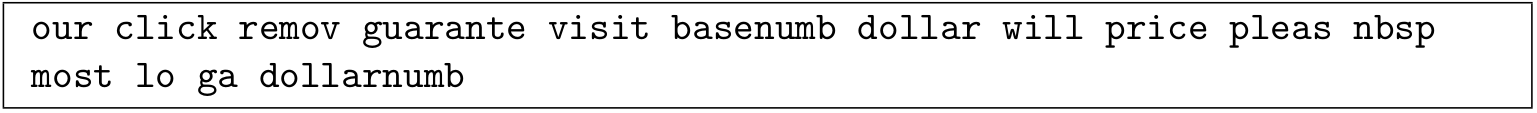

<div style="border-style: solid; border-width: 1px; margin: 10px 10px 10px 10px; padding: 10px 10px 10px 10px">
our  click  remov guarante visit basenumb dollar pleas price will nbsp most lo ga hour
</div>

Thus, if an email contains words such as “guarantee”, “remove”, “dollar”, and “price” (the top predictors shown in the figure), it is likely to be classified as spam.

Since the model we are training is a linear SVM, we can inspect the weights learned by the model to understand better how it is determining whether an email is spam or not. The following code finds the words with the highest weights in the classifier. Informally, the classifier 'thinks' that these words are the most likely indicators of spam.


In [34]:
# Sort the weights and obtin the vocabulary list
# NOTE some words have the same weights,
# so their order might be different than in the text above
idx = np.argsort(model['w'])
top_idx = idx[-15:][::-1]
vocabList = utils.getVocabList()

print('Top predictors of spam:')
print('%-15s %-15s' % ('word', 'weight'))
print('----' + ' '*12 + '------')
for word, w in zip(np.array(vocabList)[top_idx], model['w'][top_idx]):
    print('%-15s %0.2f' % (word, w))


Top predictors of spam:
word            weight         
----            ------
our             0.50
click           0.47
remov           0.43
guarante        0.39
visit           0.37
basenumb        0.35
dollar          0.33
price           0.27
will            0.27
pleas           0.26
lo              0.25
nbsp            0.25
most            0.25
ga              0.24
al              0.24


### 2.5 Try your own emails

Now that you have trained a spam classifier, you can start trying it out on your own emails. In the starter code, we have included two email examples (`emailSample1.txt` and `emailSample2.txt`) and two spam examples (`spamSample1.txt` and `spamSample2.txt`). The next cell runs the spam classifier over the first spam example and classifies it using the learned SVM. You should now try the other examples we have provided and see if the classifier gets them right. You can also try your own emails by replacing the examples (plain text files) with your own emails.


In [35]:
filename = os.path.join('Data', 'emailSample1.txt')

with open(filename) as fid:
    file_contents = fid.read()

word_indices = processEmail(file_contents, verbose=False)
x = emailFeatures(word_indices)
p = utils.svmPredict(model, x)

print('\nProcessed %s\nSpam Classification: %s' % (filename, 'spam' if p else 'not spam'))


Processed Data\emailSample1.txt
Spam Classification: not spam


### 2.6 Build your own dataset

In this exercise, we provided a preprocessed training set and test set. These datasets were created using the same functions (`processEmail` and `emailFeatures`) that you now have completed. For this exercise, you will build your own dataset using the original emails from the SpamAssassin Public Corpus.

Your task in this exercise is to download the original
files from the public corpus and extract them. After extracting them, you should run the `processEmail` and `emailFeatures` functions on each email to extract a feature vector from each email. This will allow you to build a dataset `X`, `y` of examples. You should then randomly divide up the dataset into a training set, a cross validation set and a test set.

While you are building your own dataset, we also encourage you to try building your own vocabulary list (by selecting the high frequency words that occur in the dataset) and adding any additional features that you think
might be useful. Finally, we also suggest trying to use highly optimized SVM toolboxes such as [`LIBSVM`](https://www.csie.ntu.edu.tw/~cjlin/libsvm/) or [`scikit-learn`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm).
